In [10]:
import torch
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import torch.nn.functional as F
import os
import cv2 # 이미지 컬러맵 및 오버레이를 위한 OpenCV
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib # 한글 폰트 설정

In [11]:
# --- 설정 및 변수 정의 ---
# TODO: 데이터셋 경로 확인 및 클래스 이름 가져오기 코드를 실제 환경에 맞게 수정하세요.
# 학습 시 사용했던 동일한 이미지 전처리 파이프라인 정의 (모델 입력용)
inference_transform_model_input = transforms.Compose([
    transforms.Resize(256), # 이미지 크기 조절
    transforms.CenterCrop(224), # 중앙 자르기
    transforms.ToTensor(), # 파이토치 텐서로 변환 (0-255 -> 0-1)
    transforms.Normalize(mean=[0.48235, 0.45882, 0.40784], std=[0.229, 0.224, 0.225]) # 정규화
])

In [12]:
# 클래스 이름 가져오기 (학습 시 사용했던 것과 동일해야 합니다)
# ImageFolder 객체를 임시로 생성하여 클래스 이름을 가져오는 방법 (데이터 폴더가 존재해야 함)
try:
    # ImageFolder는 하위 폴더 이름을 클래스 이름으로 사용합니다. './data/train' 경로를 확인하세요.
    temp_dataset = ImageFolder('./data/train', transform=inference_transform_model_input)
    class_names = temp_dataset.classes # 클래스 이름 (폴더 이름) 리스트
    print(f"데이터셋 폴더에서 클래스 이름 {class_names} 을(를) 성공적으로 불러왔습니다.")
except Exception as e:
    print(f"데이터셋 폴더에서 클래스 이름을 불러오는 데 실패했습니다. 오류: {e}")
    print("클래스 이름을 직접 정의하거나, ImageFolder 경로를 수정해주세요.")
    # TODO: 실패 시 실제 학습에 사용된 클래스 이름 리스트로 교체 필요!
    # 예: class_names = ['cheetah_train_resized', 'hyena_train_resized', 'tiger_train_resized']
    class_names = [f'class_{i}' for i in range(3)] # 예시로 3개 클래스 가정 (실제 개수에 맞게 수정)
    print(f"임시 클래스 이름 {class_names} 을(를) 사용합니다.")

데이터셋 폴더에서 클래스 이름 ['cheetah_train_resized', 'hyena_train_resized', 'tiger_train_resized'] 을(를) 성공적으로 불러왔습니다.


In [13]:
# 클래스 이름 매핑 딕셔너리 (모델 출력 이름(폴더 이름)을 원하는 한글 이름으로 변환하기 위해 사용)
# TODO: 실제 class_names 리스트의 항목과 원하는 한글 이름을 여기에 맞게 정의하세요.
class_name_mapping = {
    'cheetah_train_resized': '치타',
    'hyena_train_resized': '하이에나',
    'tiger_train_resized': '호랑이'
    # 예시: '클래스1_폴더이름': '원하는 한글 이름'
}
print(f"클래스 이름 변환 매핑: {class_name_mapping}")

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' # 사용 가능한 경우 GPU, 아니면 CPU 사용
MODEL_PATH = './best_VGG11_model.pt' # 저장된 모델 가중치 파일 경로

클래스 이름 변환 매핑: {'cheetah_train_resized': '치타', 'hyena_train_resized': '하이에나', 'tiger_train_resized': '호랑이'}


In [14]:
# --- 모델 로드 ---
# 모델 구조 정의 (학습 시 사용했던 것과 동일해야 합니다)
# weights=None으로 구조만 불러옵니다. (저장된 가중치를 로드할 것이기 때문)
model = models.vgg11(weights = None)
num_classes = len(class_names) # 데이터셋에서 가져온 클래스 개수
# 최종 분류기 레이어를 학습 시와 동일하게 새로운 선형 레이어로 교체
model.classifier[6] = torch.nn.Linear(4096, num_classes)

In [15]:
# 저장된 모델 가중치 로드
if os.path.exists(MODEL_PATH):
    print(f"모델 가중치 파일 '{MODEL_PATH}'을 로드합니다.")
    # map_location=DEVICE는 저장된 가중치를 지정된 디바이스로 로드합니다.
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model = model.to(DEVICE) # 모델을 지정된 디바이스로 이동
    model.eval() # 모델을 평가 모드로 설정 (추론 시 필수)
    print("모델 가중치 로드 및 평가 모드 설정 완료.")
else:
    print(f"오류: 모델 가중치 파일 '{MODEL_PATH}'을 찾을 수 없습니다.")
    print("모델 파일 경로를 확인하거나, 학습 코드를 다시 실행하여 모델을 저장해주세요.")
    exit() # 파일이 없으면 프로그램 종료

모델 가중치 파일 './best_VGG11_model.pt'을 로드합니다.


C:\Users\KDP-34\AppData\Local\Temp\ipykernel_17224\1465260474.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=D

모델 가중치 로드 및 평가 모드 설정 완료.


In [16]:
# --- Grad-CAM 함수 정의 ---
def get_grad_cam(model, image_tensor, target_layer, target_category=None):
    """
    주어진 모델, 이미지 텐서, 타겟 레이어에 대한 Grad-CAM 히트맵을 생성합니다.

    Args:
        model (torch.nn.Module): PyTorch 모델.
        image_tensor (torch.Tensor): 모델 입력 이미지 텐서 (배치 차원 포함, ToTensor 및 Normalize 후).
        target_layer (torch.nn.Module): 특징 맵과 그래디언트를 가져올 합성곱 레이어.
        target_category (int, optional): 타겟 클래스 인덱스. None이면 모델의 예측 클래스를 사용합니다.

    Returns:
        numpy.ndarray: [0, 1]로 정규화된 Grad-CAM 히트맵 NumPy 배열 (높이, 너비).
                       훅 실패 또는 그래디언트가 없는 경우 None 반환.
    """
    model.eval() # 모델이 평가 모드인지 다시 확인

    feature_maps = [] # 특징 맵을 저장할 리스트
    gradients = [] # 그래디언트를 저장할 리스트

    # 특징 맵을 저장하기 위한 포워드 훅 함수
    def forward_hook(module, input, output):
        feature_maps.append(output.clone().detach()) # 클론하고 detach하여 그래디언트 계산에서 제외
        # output은 [Batch, Channels, H, W] 형태

    # 그래디언트를 저장하기 위한 백워드 훅 함수
    def backward_hook(module, grad_input, grad_output):
        # grad_output[0]는 해당 모듈 출력에 대한 손실의 그래디언트
        gradients.append(grad_output[0].clone().detach()) # 클론하고 detach
        # grad_output[0]은 [Batch, Channels, H, W] 형태

    # 타겟 레이어에 훅 등록
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    # 포워드 패스 실행
    output = model(image_tensor)

    # 타겟 클래스 결정
    if target_category is None:
        target_category = torch.argmax(output, dim=1).item()

    # 그래디언트 초기화
    model.zero_grad()

    # 타겟 클래스 로짓에 대한 그래디언트 계산
    one_hot = torch.zeros_like(output).to(image_tensor.device)
    one_hot[0][target_category] = 1
    output.backward(gradient=one_hot, retain_graph=True)

    # 데이터 캡처 확인 및 훅 해제
    if not feature_maps or not gradients:
        print("오류: 특징 맵 또는 그래디언트 캡처에 실패했습니다. 타겟 레이어를 확인하세요.")
        forward_handle.remove()
        backward_handle.remove()
        return None

    feature_map = feature_maps[0] # Shape: [1, Channels, H_feature, W_feature]
    gradient = gradients[0]     # Shape: [1, Channels, H_feature, W_feature]

    forward_handle.remove()
    backward_handle.remove()

    # --- 기존 Grad-CAM 가중치 계산 ---
    # weights = torch.mean(gradient, dim=(2, 3), keepdim=True)

    # --- XGrad-CAM 방식에 가까운 가중치 계산으로 수정 ---
    # 그래디언트와 특징 맵의 요소별 곱의 공간적 평균을 가중치로 사용
    # 이는 그래디언트와 활성화 값을 함께 고려하는 방식입니다.
    # weights shape: [1, Channels, 1, 1]
    weights = torch.mean(gradient * feature_map, dim=(2, 3), keepdim=True)
    # --- 수정된 가중치 계산 끝 ---


    # Grad-CAM 계산 (수정된 가중치 사용)
    cam = torch.sum(weights * feature_map, dim=1, keepdim=True)

    # ReLU 적용
    cam = F.relu(cam)

    # ... (CAM 크기 보간, 정규화, NumPy 변환 등 나머지 부분은 이전 코드와 동일) ...

    # CAM 크기를 모델 입력 이미지의 공간적 크기 (예: 224x224)로 보간
    input_h, input_w = image_tensor.shape[2], image_tensor.shape[3]
    cam = F.interpolate(cam, size=(input_h, input_w), mode='bilinear', align_corners=False)

    # CAM을 [0, 1] 범위로 정규화
    cam = cam.squeeze(0).squeeze(0)
    if cam.max() == cam.min():
         print("경고: Grad-CAM 히트맵 값이 모두 동일합니다 (모델이 특징을 구분하지 못할 수 있습니다).")
         return np.zeros((input_h, input_w), dtype=np.float32)

    cam = (cam - cam.min()) / (cam.max() - cam.min())

    return cam.cpu().numpy()

In [17]:
# --- 히트맵 오버레이 헬퍼 함수 ---
def overlay_heatmap(original_img_pil, heatmap_np):
    """
    원본 PIL 이미지 위에 히트맵을 겹쳐서 시각화합니다.

    Args:
        original_img_pil (PIL.Image.Image): 원본 이미지.
        heatmap_np (numpy.ndarray): [0, 1]로 정규화된 히트맵 NumPy 배열 [높이, 너비].
                                   모델 입력 이미지의 공간 크기와 일치해야 합니다.

    Returns:
        PIL.Image.Image: 히트맵이 오버레이된 이미지.
    """
    # 원본 PIL 이미지를 NumPy 배열 (높이, 너비, 채널)로 변환 - RGB 형태
    original_img_np = np.array(original_img_pil)

    # 히트맵 크기를 원본 PIL 이미지 크기로 조정
    original_h, original_w = original_img_np.shape[0], original_img_np.shape[1]
    # cv2.resize는 너비, 높이 순서 (np.shape는 높이, 너비 순서)
    heatmap_resized = cv2.resize(heatmap_np, (original_w, original_h), interpolation=cv2.INTER_LINEAR)

    # 히트맵에 컬러맵 적용 (예: cv2.COLORMAP_JET 또는 cv2.COLORMAP_HOT)
    # 컬러맵 적용 전 히트맵 값을 0-255 범위의 uint8로 변환
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

    # 원본 이미지 NumPy 배열을 RGB에서 BGR로 변환 (OpenCV는 기본적으로 BGR 사용)
    original_img_bgr = cv2.cvtColor(original_img_np, cv2.COLOR_RGB2BGR)

    # addWeighted를 사용하여 히트맵 오버레이 (혼합)
    # 결과 = 원본_이미지 * alpha + 컬러맵_히트맵 * beta + gamma
    # alpha: 원본 이미지 가중치, beta: 히트맵 가중치
    overlayed_img_bgr = cv2.addWeighted(original_img_bgr, 0.6, heatmap_colored, 0.4, 0) # alpha, beta 값 조정 가능

    # Matplotlib 또는 PIL 표시를 위해 다시 BGR에서 RGB로 변환
    overlayed_img_rgb = cv2.cvtColor(overlayed_img_bgr, cv2.COLOR_BGR2RGB)

    # PIL Image 객체로 변환하여 반환
    return Image.fromarray(overlayed_img_rgb)

'./test/치타.jpg' 이미지 분류 및 XGrad-CAM 생성 시작...
원본 이미지 로드 완료.
이미지 전처리 및 디바이스 이동 완료.

--- 최종 분류 결과 (전체 네트워크 사용) ---
예측 클래스: 치타
각 클래스 확률:
  치타: 1.0000
  하이에나: 0.0000
  호랑이: 0.0000
---------------------------------------

XGrad-CAM 생성을 위한 타겟 레이어: Conv2d (features[18])
XGrad-CAM 히트맵 생성 완료.
히트맵 오버레이 이미지 생성 완료.
결과 이미지를 표시합니다.


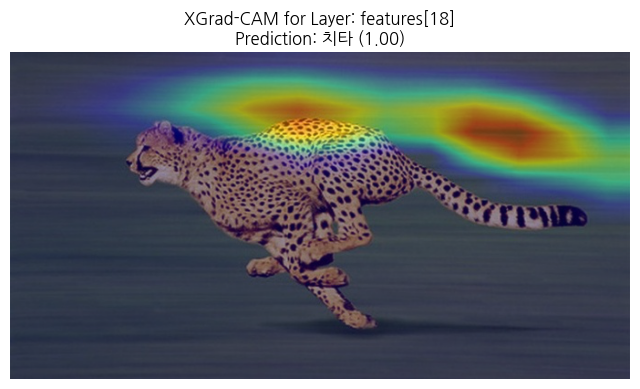

In [19]:
# --- 메인 실행 부분 ---

# TODO: 분류할 새로운 이미지 파일 경로를 여기에 입력하세요.
new_image_path = './test/치타.jpg' # 실제 이미지 파일 경로로 변경해야 합니다!

# 이미지 파일이 존재하는지 확인
if not os.path.exists(new_image_path):
    print(f"오류: 이미지 파일 '{new_image_path}'을 찾을 수 없습니다.")
else:
    try:
        print(f"'{new_image_path}' 이미지 분류 및 XGrad-CAM 생성 시작...")

        # 1. 원본 이미지 로드 (나중에 히트맵 오버레이에 사용)
        original_image_pil = Image.open(new_image_path).convert('RGB')
        print("원본 이미지 로드 완료.")

        # 2. 모델 입력용 이미지 전처리 및 디바이스 이동
        # 학습 시 사용한 것과 동일한 전처리 적용
        image_tensor = inference_transform_model_input(original_image_pil).unsqueeze(0).to(DEVICE) # 배치 차원(unsqueeze(0)) 추가 및 디바이스 이동
        print("이미지 전처리 및 디바이스 이동 완료.")

        # 3. 이미지 분류 수행 (이 부분은 한 번만 수행됩니다 - 최종 예측)
        with torch.no_grad(): # 예측 시에는 그래디언트 계산 불필요
            output = model(image_tensor) # 모델 포워드 패스 -> 로짓 출력

        # 예측 클래스 및 확률 계산
        probs = F.softmax(output, dim=1)[0] # 로짓을 확률로 변환. 배치에 이미지 하나 -> [0] 인덱싱
        predicted_index = torch.argmax(probs).item() # 가장 높은 확률을 가진 클래스 인덱스
        original_predicted_class_name = class_names[predicted_index] # ImageFolder에서 가져온 원래 클래스 이름

        # 클래스 이름 매핑을 사용하여 출력용 한글 이름 가져오기
        predicted_korean_name = class_name_mapping.get(original_predicted_class_name, original_predicted_class_name) # 매핑에 없으면 원래 이름 사용

        # 분류 결과 출력
        print("\n--- 최종 분류 결과 (전체 네트워크 사용) ---")
        print(f"예측 클래스: {predicted_korean_name}")
        print("각 클래스 확률:")
        # 각 클래스 이름과 확률 함께 출력 (확률은 CPU로 이동 후 NumPy 변환)
        for i, prob in enumerate(probs.cpu().numpy()):
            original_class_name = class_names[i]
            korean_class_name = class_name_mapping.get(original_class_name, original_class_name) # 매핑에 없으면 원래 이름 사용
            print(f"  {korean_class_name}: {prob:.4f}")
        print("---------------------------------------\n")

        # 4. XGrad-CAM 생성 (마지막 컨볼루션 레이어에 대해)
        # XGrad-CAM을 적용할 타겟 레이어 지정
        # VGG11의 features 시퀀셜 모듈에서 마지막 Conv2d 레이어를 찾습니다.
        # 모델 구조(print(model) 실행 결과)를 보고 정확한 인덱스 확인 필요. 보통 18번 인덱스입니다.
        target_layer_index = 18 # 마지막 Conv2d 레이어 인덱스로 설정
        target_layer = model.features[target_layer_index] # 예: VGG11의 마지막 Conv2d 레이어

        # 해당 인덱스가 Conv2d 레이어인지 확인 (안전 장치)
        if not isinstance(target_layer, torch.nn.Conv2d):
             print(f"오류: features[{target_layer_index}]는 Conv2d 레이어가 아닙니다. 타겟 레이어 인덱스를 확인하세요.")
             # XGrad-CAM 생성을 건너뜁니다.
        else:
            print(f"XGrad-CAM 생성을 위한 타겟 레이어: {target_layer.__class__.__name__} (features[{target_layer_index}])")

            # 예측된 클래스(predicted_index)에 대한 XGrad-CAM 히트맵 생성
            # get_grad_cam 함수는 예측 클래스 인덱스를 사용하여 해당 클래스에 대한 CAM을 계산합니다.
            heatmap = get_grad_cam(model, image_tensor, target_layer, target_category=predicted_index)
            print("XGrad-CAM 히트맵 생성 완료.")

            # 5. 히트맵 시각화 (원본 이미지에 오버레이)
            if heatmap is not None:
                # 원본 이미지 위에 생성된 히트맵 오버레이
                overlayed_image = overlay_heatmap(original_image_pil, heatmap)
                print("히트맵 오버레이 이미지 생성 완료.")

                # 결과 이미지 표시
                print("결과 이미지를 표시합니다.")
                plt.figure(figsize=(8, 8)) # 이미지 표시 크기 설정
                plt.imshow(overlayed_image)
                plt.title(f'XGrad-CAM for Layer: features[{target_layer_index}]\nPrediction: {predicted_korean_name} ({probs[predicted_index]:.2f})') # 제목 설정
                plt.axis('off') # 그래프 축 정보 숨기기
                plt.show() # 이미지 보여주기
            else:
                print("XGrad-CAM 히트맵 생성 과정에 문제가 발생했습니다.")

    except Exception as e:
        print(f"코드 실행 중 예상치 못한 오류 발생: {e}")